# Tariff Recommendations

<b>Aim</b>

Make a classification model that will choose the suitable tariff.

<b>Project Stages</b>

1. Opening the data file and studying the general information
2. Splitting the data into samples
3. Investigating the models
4. Testing the best model on the test sample
5. Checking the model for adequacy
6. Conclusion

<b>Data Description</b>

Each object in the dataset is the information about one user's behavior for a month.
- сalls — number of calls,
- minutes — total call duration in minutes,
- messages — number of sms messages,
- mb_used — consumed internet traffic in Mb,
- is_ultra — which tariff the user had for the month ("Ultra" — 1, "Smart" — 0).

## Opening the data file and studying the general information

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
import warnings
import graphviz
warnings.simplefilter("ignore")

In [26]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

In [27]:
pd.set_option('display.max_columns', None)
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [29]:
# considering that the number of calls and messages can't be a fraction, 
# it might be worth changing the data type of these features.

df['calls'] = df['calls'].astype('Int64')
df['messages'] = df['messages'].astype('Int64')
df['is_ultra'] = df['is_ultra'].astype('Int64')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   Int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   Int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   Int64  
dtypes: Int64(3), float64(2)
memory usage: 135.1 KB


In [31]:
df.duplicated().sum()

0

<b>Conclusions</b>: No missing data, zero values, or duplicates; the type of two columns has been changed; we can move on to the main part of the project.

In [32]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


We see that there is a very strong correlation between the number of calls and minutes. Let's calculate the Variance Inflation Factor (VIF).

In [33]:
df['calls'] = df['calls'].astype('float64')
df['messages'] = df['messages'].astype('float64')
df['is_ultra'] = df['is_ultra'].astype('float64')

#Calculating the VIF
df_vif = df.loc[:, list(df.columns)]
vif = pd.DataFrame() 
vif["Attribute"] = df_vif.columns 
vif['vif_scores'] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))] 
  
vif

,Attribute,vif_scores
0,calls,129.355144
1,minutes,126.502139
2,messages,2.236643
3,mb_used,4.467798
4,is_ultra,1.577978


Thus, we see that the features calls and minutes have a very high VIF, confirming multicollinearity. This suggests it's not advisable to include both features in the model. It's better to remove one of them — we'll choose the feature with the highest VIF value: calls. Before doing so, let's check the VIFs of the features excluding calls.

In [34]:
df_good = df.drop(['calls'], axis=1)
df_vif_good = df_good.loc[:, list(df_good.columns)]
vif_good = pd.DataFrame() 
vif_good["Attribute"] = df_vif_good.columns 
vif_good['vif_scores'] = [variance_inflation_factor(df_vif_good.values, i) for i in range(len(df_vif_good.columns))] 
  
vif_good

,Attribute,vif_scores
0,minutes,4.136889
1,messages,2.232629
2,mb_used,4.403647
3,is_ultra,1.577919


Confirmed, we've eliminated multicollinearity.

In [35]:
len(df_good.loc[df_good['is_ultra'] == 1])/len(df_good.loc[df_good['is_ultra']])

0.30647168637212197

Class 1 is slightly more than 30% of the entire dataset - as far as I understand, this is right "on the edge" of being balanced.

## Splitting the data into samples

In [36]:
# we create 3 samples: training, validation, and testing.

df_good_features = df_good.drop(['is_ultra'], axis=1)
df_good_target = df_good['is_ultra']
df_train, df_valid_and_test = train_test_split(df_good, test_size=0.4, random_state=12345, stratify=df_good_target)

df_valid_and_test_features = df_valid_and_test.drop(['is_ultra'], axis=1)
df_valid_and_test_target = df_valid_and_test['is_ultra']
df_valid, df_test = train_test_split(df_valid_and_test, test_size=0.5, random_state=12345, stratify=df_valid_and_test_target)

In [37]:
# setting up a feature set and target feature for each of the samples:

#training
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

#validation
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

#testing
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [38]:
df_train.shape

(1928, 4)

In [39]:
df_valid.shape

(643, 4)

In [40]:
df_test.shape

(643, 4)

The quantitative division was done correctly.

## Investigating the models

### Decision Tree

In [41]:
best_model_dt = None
best_result_dt = 0
best_depth_dt = 0
for depth in range(1, 20):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train)
    predictions_dt_valid = model_dt.predict(features_valid)
    result_dt = accuracy_score(target_valid, predictions_dt_valid)
    if result_dt > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result_dt
        best_depth_dt = depth

print('Accuracy of the best Decision Tree model on the validation sample:', best_result_dt, 'in max_depth:', best_depth_dt)

Accuracy of the best Decision Tree model on the validation sample: 0.7916018662519441 in max_depth: 8


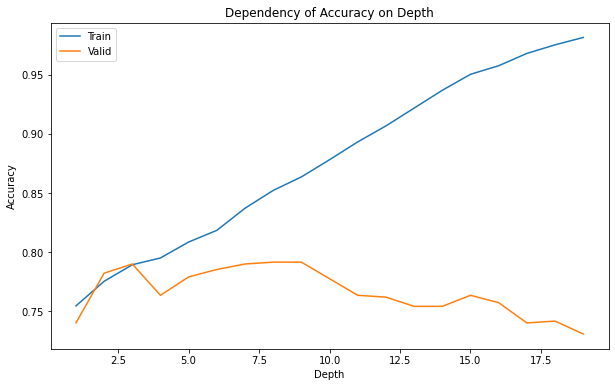

In [42]:
max_depth_list = list(range(1,20))
train_list = []
valid_list = []

for depth in range(1, 20):
    model_dt_fig = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt_fig.fit(features_train, target_train)
    predictions_dt_valid_fig = model_dt_fig.predict(features_valid)
    predictions_dt_train_fig = model_dt_fig.predict(features_train)
    valid_list.append(accuracy_score(target_valid, predictions_dt_valid_fig))
    train_list.append(accuracy_score(target_train, predictions_dt_train_fig))

x_plt = np.arange(len(max_depth_list)) + 1
plt.figure(figsize=(10,6))
plt.plot(x_plt, train_list, label='Train')
plt.plot(x_plt, valid_list, label='Valid')
plt.title('Dependency of Accuracy on Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

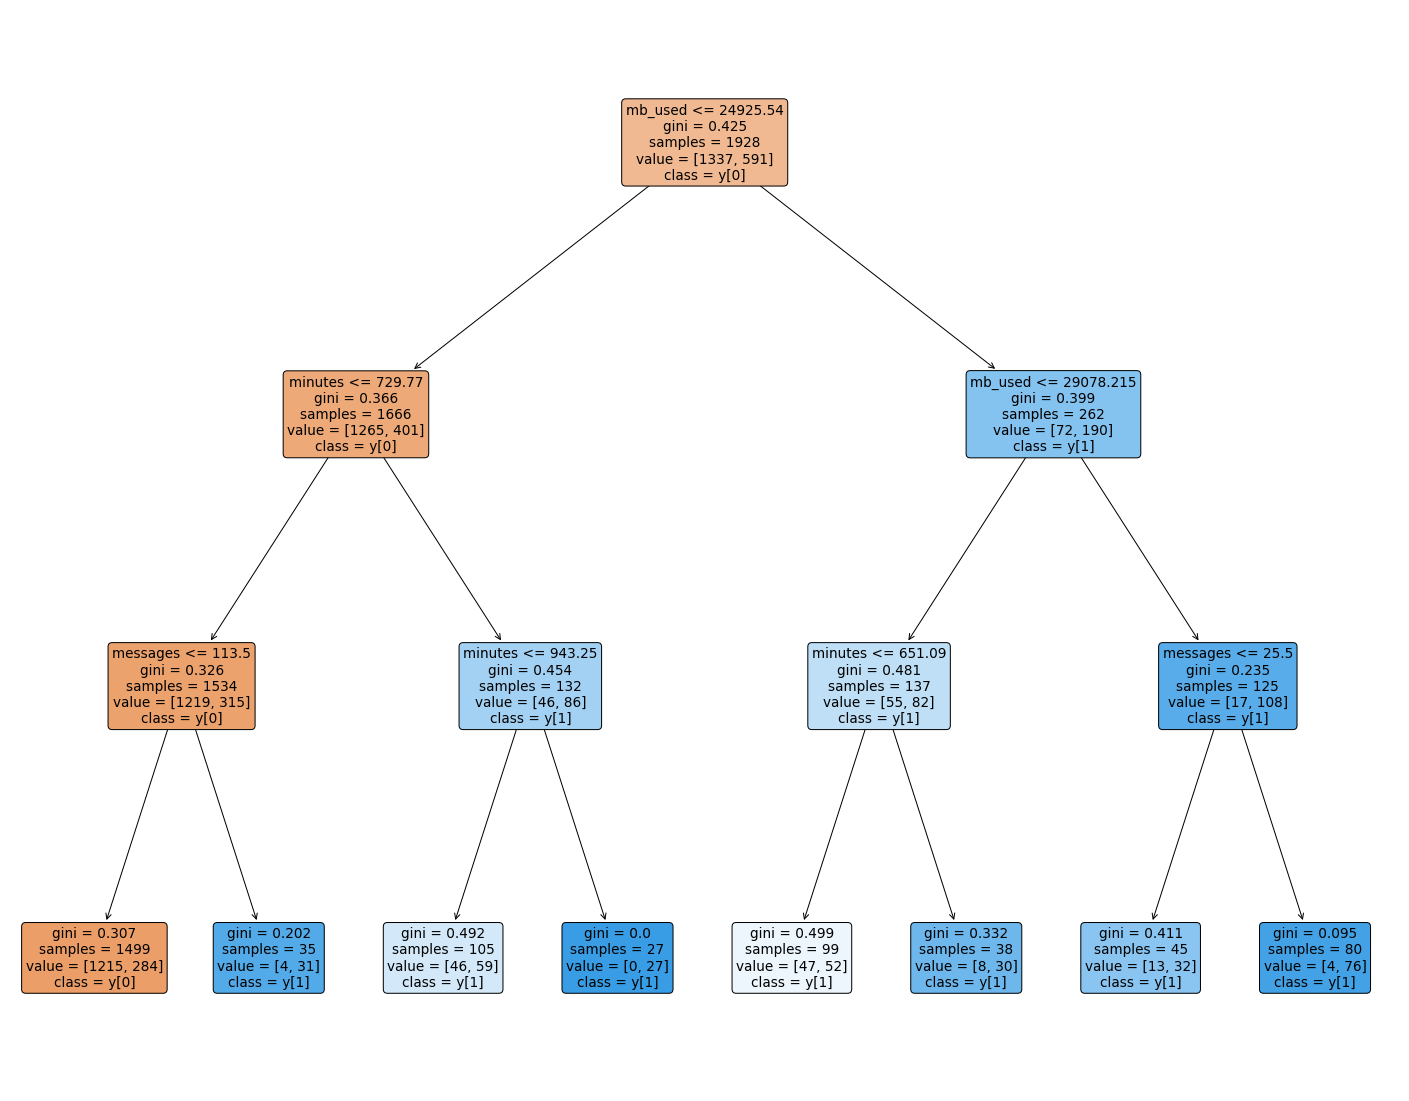

In [43]:
fig = plt.figure(figsize=(25,20))
model_dt_fig_tree = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_dt_fig_tree = model_dt_fig_tree.fit(features_train, target_train)
tree.plot_tree(model_dt_fig_tree, 
               feature_names=features_train.columns,
               class_names=True,
               filled=True, rounded=True)
plt.show()

### Random Forest

In [44]:
best_model_rf = None
best_result_rf = 0
best_depth_rf = 0
best_est_rf = 0
for est in tqdm(range(1,20)):
    for depth in range(1, 20):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_train, target_train)
        prediction_forest = model_rf.predict(features_valid)
        result_rf = accuracy_score(prediction_forest,target_valid)
        if result_rf > best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result_rf
            best_depth_rf = depth
            best_est_rf = est

print('Accuracy of the best Random Forest model on the validation sample:', best_result_rf, 'in max_depth:', best_depth_rf,
      'and n_estimators:', best_est_rf)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.67it/s]

Accuracy of the best Random Forest model on the validation sample: 0.8118195956454122 in max_depth: 8 and n_estimators: 18


### Logistic Regression

In [45]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)
prediction_lr_valid=model_lr.predict(features_valid)
accuracy_lr = accuracy_score(prediction_lr_valid, target_valid)
print('Accuracy of the Logistic Regression model on the validation sample', accuracy_lr)

Accuracy of the Logistic Regression model on the validation sample 0.71850699844479


<b>Conclusions</b>: Thus, the best Accuracy on the validation sample is shown by the Random Forest model.

## Testing the Best Model on the Test Sample

In [46]:
#We found out that the best model is Random Forest. Let's test it on the test sample.

model_rf_test = RandomForestClassifier(random_state=12345, n_estimators=best_est_rf, max_depth=best_depth_rf)
model_rf_test.fit(features_train, target_train)
prediction_rf_test = model_rf_test.predict(features_test)
result_rf_test = accuracy_score(target_test, prediction_rf_test)
print('Accuracy of the Random Forest model on the test sample:', result_rf_test)

Accuracy of the Random Forest model on the test sample: 0.8102643856920684


<b>Conclusions</b>: Thus, the most accurate model when working on the test sample is Random Forest.

In [47]:
features_train_valid = pd.concat([features_train, features_valid], ignore_index = True)
target_train_valid = pd.concat([target_train, target_valid], ignore_index = True) 

model_rf_test_t_v = RandomForestClassifier(random_state=12345, n_estimators=best_est_rf, max_depth=best_depth_rf)
model_rf_test_t_v.fit(features_train_valid, target_train_valid)
prediction_rf_test = model_rf_test_t_v.predict(features_test)
result_rf_test_t_v = accuracy_score(target_test, prediction_rf_test)
print('Accuracy of the Random Forest model on the test sample:', result_rf_test_t_v)

Accuracy of the Random Forest model on the test sample: 0.8320373250388803


Indeed, training on the combined sample (training + validation) led to an increase in the accuracy of the Random Forest model.

## Checking the Model for Adequacy

In [48]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_model.fit(features_train, target_train)
result_dummy_model = dummy_model.score(features_test, target_test)
if   result_rf_test > result_dummy_model:
    print('The Random Forest model is adequate')
else:
    print('The model did not pass the adequacy check')

The Random Forest model is adequate


## Conclusion

We were tasked with building a classification model that would select the appropriate tariff.

We analyzed the dataset. The most important finding was multicollinearity, which arose due to the very strong correlation between two features - the number of calls and the spent minutes. This issue was resolved by removing the feature with the highest Variance Inflation Factor (VIF) from the dataset - calls.

Subsequently, we allocated 3 samples for training and testing models - training, validation, and testing. We trained 3 models - Decision Tree, Random Forest, and Logistic Regression. When checked on the validation sample, the Random Forest model showed the best Accuracy.

When testing the model on the test sample, the model demonstrated a high Accuracy result - above 0.81. The model was improved by training it on a sample that simultaneously consisted of training and validation samples. Accuracy was raised to 0.83. Additionally, the Random Forest model passed the adequacy check.